

#Ideal Quantum Walks Simulations


## 📝 Introduction
The Galton Box is a classic device that demonstrates how a series of random events can lead to a predictable outcome. As a ball navigates through rows of pegs, each bounce is a 50/50 chance of going left or right. The accumulation of these random choices results in the final positions of many balls forming a binomial distribution, which for many layers approximates a normal (Gaussian) curve. This process is a simple physical example of a Monte Carlo method, where repeated random sampling is used to understand a system.

In this project, we create a quantum version of this process. Instead of a classical ball, we use qubits. A single "ancilla" qubit acts as a quantum coin. By placing it in a superposition, we can simulate the probabilistic "bounce" at each peg. A register of "position" qubits tracks the path taken. This quantum walk allows us to precisely simulate and control the final probability distribution.

This notebook covers the ideal, noiseless simulations for this quantum walk.

## Task 2: The Ideal Binomial Walk
To perfectly replicate a classical Galton Box, the probability of our quantum coin landing on "left" or "right" must be exactly 50/50. We achieve this by applying a Hadamard (H) gate to the ancilla qubit at each layer. The H gate places the ancilla in an equal superposition of the ∣0⟩ (left) and ∣1⟩ (right) states. A subsequent Controlled-NOT (CX) gate then uses the ancilla's state to update the position register.

After running the simulation for many "shots," we expect the final distribution of positions to match the theoretical binomial distribution B(n, p) where n is the number of layers and p=0.5. We verify the accuracy of our simulation by calculating the Kullback-Leibler (KL) Divergence between our simulated result and the ideal curve. A KL divergence near zero signifies a near-perfect match.

In [ ]:
!pip install qiskit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 6.8 MB/s eta 0:00:00


In [ ]:
!pip install qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 94.4 MB/s eta 0:00:00


Starting simulation...


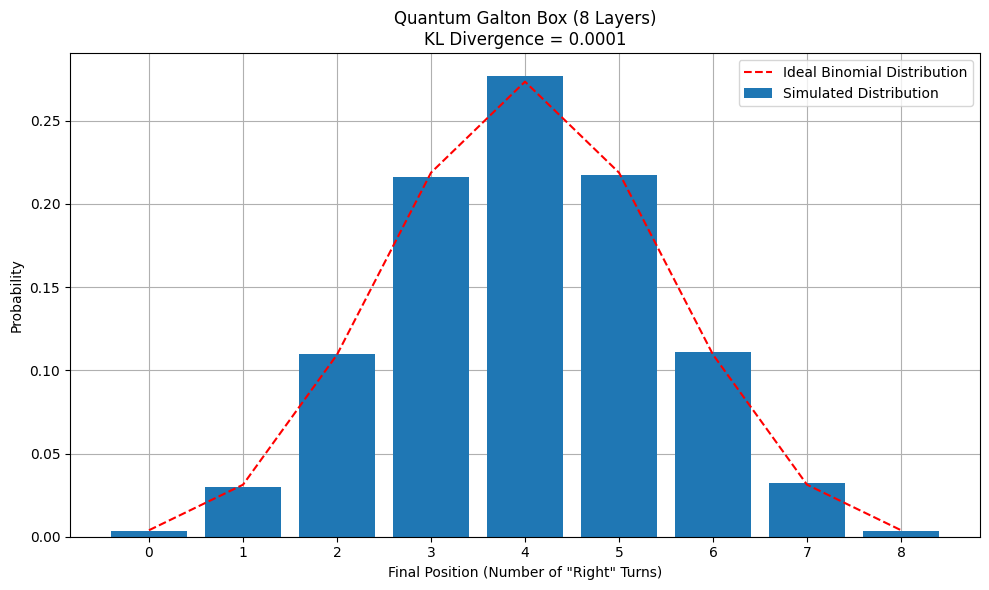

KL Divergence: 0.00011669800591881973
Simulation completed in: 0.16 seconds


In [ ]:
# 1. IMPORT LIBRARIES

import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from scipy.stats import binom, entropy
import time

# 2. DEFINE HELPER FUNCTIONS

def build_galton_box_circuit(n_layers):
    """
    Creates a quantum circuit to simulate a Galton Box.

    Args:
        n_layers (int): The number of layers of pegs in the box.

    Returns:
        QuantumCircuit: The executable quantum circuit.
    """

    # Allocate qubits: n_layers for position tracking, plus one ancilla for the 'coin'.
    position_qubits = n_layers
    ancilla_qubit = n_layers
    qc = QuantumCircuit(position_qubits + 1, position_qubits)

    # For each layer, perform a quantum 'coin flip' and update the position.
    for i in range(n_layers):

        # Apply Hadamard to the ancilla to create a 50/50 superposition of |0> and |1>.
        qc.h(ancilla_qubit)

        # Use a CNOT gate to flip the i-th position qubit if the ancilla is |1>.
        qc.cx(ancilla_qubit, i)

        # Reset the ancilla to |0> for a clean state in the next layer.
        qc.reset(ancilla_qubit)

    # Measure the position qubits to get the final outcome.
    qc.measure(range(position_qubits), range(position_qubits))

    return qc

def process_counts_for_galton(counts_dict, n_layers):
    """
    Processes the raw counts from the simulator.

    Args:
        counts_dict (dict): A dictionary of bitstring results and their counts.
        n_layers (int): The number of layers in the simulation.

    Returns:
        dict: A dictionary of final positions and their total counts.
    """

    # Initialize a dictionary to store counts for each possible final position (0 to n_layers).
    positions = {i: 0 for i in range(n_layers + 1)}

    # For each measured bitstring, determine the final position.
    for bitstring, count in counts_dict.items():

        # The final position is the total number of 'right' turns, which is the number of '1's in the bitstring (its Hamming weight).
        pos = bitstring.count('1')
        if pos in positions:
            positions[pos] += count

    return positions

# 3. SETUP AND RUN THE SIMULATION

#Execute the Simulation and Track Time
print("Starting simulation...")

# Record the time right before execution
start_time = time.time()

# Define the number of layers for the Galton Box.
n_layers = 8

# Build the quantum circuit.
qc = build_galton_box_circuit(n_layers)

# Get the ideal, noiseless simulator.
simulator = Aer.get_backend('qasm_simulator')

# Execute the circuit and get the results.
result = simulator.run(qc, shots=8192).result()
counts = result.get_counts()

# Record the time right after execution finishes
end_time = time.time()

# 4. PROCESS AND ANALYZE THE RESULTS

# Convert the raw bitstring counts to final position counts.
position_counts = process_counts_for_galton(counts, n_layers)

# Convert the counts into a probability distribution.
total_shots = sum(position_counts.values())
outcomes = np.arange(n_layers + 1)
simulated_probs = np.array([position_counts.get(i, 0) / total_shots for i in outcomes])

# Calculate the ideal theoretical distribution (a Binomial distribution for p=0.5).
p = 0.5
x_ideal = np.arange(0, n_layers + 1)
binom_dist = binom.pmf(x_ideal, n_layers, p)

# Calculate the KL Divergence to measure the distance between the simulated and ideal distributions.
# A value close to 0 indicates a very close match.
kl_div = entropy(pk=simulated_probs, qk=binom_dist)

# 5. PLOT THE FINAL DISTRIBUTION

# Create a bar chart of the simulated results and overlay the ideal curve.
plt.figure(figsize=(10, 6))
plt.bar(outcomes, simulated_probs, label='Simulated Distribution', zorder=2)
plt.plot(outcomes, binom_dist, 'r--', label='Ideal Binomial Distribution', zorder=3)

# Add titles and labels for clarity.
plt.title(f'Quantum Galton Box ({n_layers} Layers)\nKL Divergence = {kl_div:.4f}')
plt.xlabel('Final Position (Number of "Right" Turns)')
plt.ylabel('Probability')
plt.xticks(outcomes)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Print the final metric.
print(f"KL Divergence: {kl_div}")

#Calculate and Print the Duration
execution_time = end_time - start_time
print(f"Simulation completed in: {execution_time:.2f} seconds")